<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Goal" data-toc-modified-id="Goal-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Goal</a></span></li><li><span><a href="#Var" data-toc-modified-id="Var-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Var</a></span></li><li><span><a href="#Init" data-toc-modified-id="Init-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Init</a></span></li><li><span><a href="#Test" data-toc-modified-id="Test-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Test</a></span></li><li><span><a href="#Community-summary" data-toc-modified-id="Community-summary-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Community summary</a></span><ul class="toc-item"><li><span><a href="#Load" data-toc-modified-id="Load-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Load</a></span><ul class="toc-item"><li><span><a href="#Train" data-toc-modified-id="Train-5.1.1"><span class="toc-item-num">5.1.1&nbsp;&nbsp;</span>Train</a></span></li></ul></li><li><span><a href="#Summary" data-toc-modified-id="Summary-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Summary</a></span></li></ul></li><li><span><a href="#Feature-table-summary" data-toc-modified-id="Feature-table-summary-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Feature table summary</a></span><ul class="toc-item"><li><span><a href="#Load" data-toc-modified-id="Load-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Load</a></span><ul class="toc-item"><li><span><a href="#Test" data-toc-modified-id="Test-6.1.1"><span class="toc-item-num">6.1.1&nbsp;&nbsp;</span>Test</a></span></li></ul></li><li><span><a href="#Summarize-misassemblies" data-toc-modified-id="Summarize-misassemblies-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Summarize misassemblies</a></span><ul class="toc-item"><li><span><a href="#Number-of-misassembled-contigs" data-toc-modified-id="Number-of-misassembled-contigs-6.2.1"><span class="toc-item-num">6.2.1&nbsp;&nbsp;</span>Number of misassembled contigs</a></span></li><li><span><a href="#Misassembly-types" data-toc-modified-id="Misassembly-types-6.2.2"><span class="toc-item-num">6.2.2&nbsp;&nbsp;</span>Misassembly types</a></span><ul class="toc-item"><li><span><a href="#Notes/WARNINGs" data-toc-modified-id="Notes/WARNINGs-6.2.2.1"><span class="toc-item-num">6.2.2.1&nbsp;&nbsp;</span>Notes/WARNINGs</a></span></li></ul></li></ul></li></ul></li><li><span><a href="#sessionInfo" data-toc-modified-id="sessionInfo-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>sessionInfo</a></span></li></ul></div>

# Goal

* Create a test datset with 30 assembly replicates
  * same as for test (n100-r30) in the Version 1 manuscript

# Var

In [1]:
work_dir = '/ebio/abt3_projects/databases_no-backup/DeepMAsED/version2/deepmased-sm/n100-r30/'

threads = 12

# Init

In [6]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(data.table)
library(dtplyr)
library(LeyLabRMisc)

In [3]:
df.dims()
set.seed(8473)
make_dir(work_dir)

Created directory: /ebio/abt3_projects/databases_no-backup/DeepMAsED/version2/deepmased-sm/n100-r30/ 


# Test

In [5]:
make_dir(file.path(work_dir, 'test'))
config_file = file.path(work_dir, 'test', 'config.yaml')
cat_file(config_file)

Directory already exists: /ebio/abt3_projects/databases_no-backup/DeepMAsED/version2/deepmased-sm/n100-r30//test 
# Input table
genomes_file: /ebio/abt3_projects/databases_no-backup/DeepMAsED/GTDB_ref_genomes/DeepMAsED_GTDB_genome-refs_test_n100.tsv

# Output directory
output_dir: /ebio/abt3_projects/databases_no-backup/DeepMAsED/version2/deepmased-sm/n100-r30/test/

# Temporary output directory (/dev/shm/ for shared memory)
tmp_dir: /ebio/abt3_scratch/

# Email for notifications ("Skip" to skip)
email: nyoungblut@tuebingen.mpg.de

# software parameters
## Use "Skip" to skip  steps. If no params for rule, use ""
## `reps:` is the number of replicate simulations
## If `keep_reads: True`, then simulated reads are kept
params:
  # simulating metagenomes
  reps: 30
  MGSIM:
    genome_download: ""
    community_richness:
      - 1
    reads: --art-paired --art-mflen 250 --art-sdev 10
    read_depth:
      - 1000000
  keep_reads: True #False
  # coverage
  nonpareil: -T kmer
  nonpareil_sum

**DeepMAsED-SM run**

```
(DeepMAsEDv2) @ rick:/ebio/abt3_projects/DeepMAsED/version2/deepmased/DeepMAsED-SM
$ screen -L -S DM-SM-n100-r30-test ./snakemake_sge.sh /ebio/abt3_projects/databases_no-backup/DeepMAsED/version2/deepmased-sm/n100-r30/test/config.yaml 20
```

# Community summary

* diversity across the simulated communities

## Load

In [16]:
#' function to read in feature tables
read_comm_table = function(infile){
    sim_rep = infile %>% dirname %>% basename
    richness = infile %>% dirname %>% dirname %>% basename
    read.delim(infile, sep='\t') %>%
        mutate(sim_rep = sim_rep,
               richness = richness)
}

comms = list()

### Train

In [17]:
comm_files = list_files(file.path(work_dir, 'test', 'MGSIM'), 'comm_wAbund.txt')
comm_files %>% length %>% print
comm_files %>% head

[1] 30


[1] "/ebio/abt3_projects/databases_no-backup/DeepMAsED/version2/deepmased-sm/n100-r30//test/MGSIM/1/1/comm_wAbund.txt" 
[2] "/ebio/abt3_projects/databases_no-backup/DeepMAsED/version2/deepmased-sm/n100-r30//test/MGSIM/1/10/comm_wAbund.txt"
[3] "/ebio/abt3_projects/databases_no-backup/DeepMAsED/version2/deepmased-sm/n100-r30//test/MGSIM/1/11/comm_wAbund.txt"
[4] "/ebio/abt3_projects/databases_no-backup/DeepMAsED/version2/deepmased-sm/n100-r30//test/MGSIM/1/12/comm_wAbund.txt"
[5] "/ebio/abt3_projects/databases_no-backup/DeepMAsED/version2/deepmased-sm/n100-r30//test/MGSIM/1/13/comm_wAbund.txt"
[6] "/ebio/abt3_projects/databases_no-backup/DeepMAsED/version2/deepmased-sm/n100-r30//test/MGSIM/1/14/comm_wAbund.txt"

In [18]:
comms = comm_files %>%
    as.list %>%
    lapply(read_comm_table) %>%
    do.call(rbind, .)

comms['dataset'] = 'test'
comms

Community,Taxon,Perc_rel_abund,Rank,sim_rep,richness,dataset
<int>,<fct>,<dbl>,<int>,<chr>,<chr>,<chr>
1,GB_GCA_002083775_1_Rhodoferax_ferrireducens,16.89854,1,1,1,test
1,RS_GCF_000175635_1_Corynebacterium_tuberculostearicum_SK141,11.86535,2,1,1,test
⋮,⋮,⋮,⋮,⋮,⋮,⋮
1,RS_GCF_002262875_1_Amycolatopsis_sp_AU_G6,0.003530533,98,9,1,test
1,RS_GCF_000974665_1_alpha_proteobacterium_U9_1i,0.002513956,99,9,1,test


## Summary

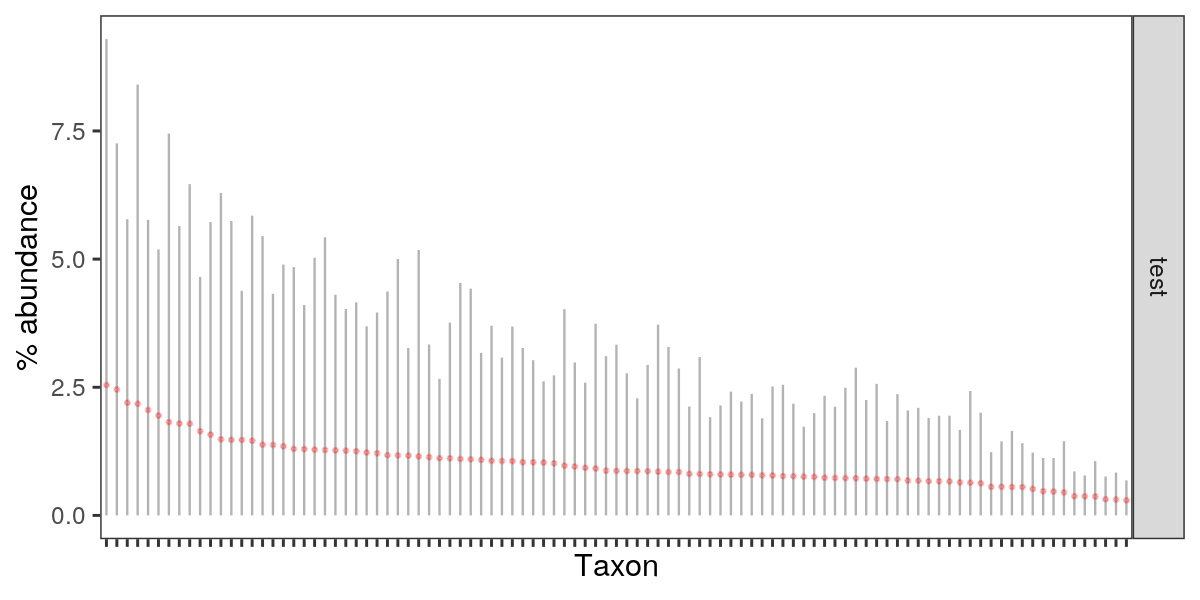

In [22]:
p = comms %>%
    mutate(Perc_rel_abund = ifelse(Perc_rel_abund == 0, 1e-5, Perc_rel_abund)) %>%
    group_by(dataset, Taxon) %>%
    summarize(mean_perc_abund = mean(Perc_rel_abund),
              sd_perc_abund = sd(Perc_rel_abund)) %>%
    ungroup() %>%
    mutate(neg_sd_perc_abund = mean_perc_abund - sd_perc_abund,
           pos_sd_perc_abund = mean_perc_abund + sd_perc_abund,
           neg_sd_perc_abund = ifelse(neg_sd_perc_abund <= 0, 1e-5, neg_sd_perc_abund)) %>%
    mutate(dataset = dataset %>% factor(levels=c('train', 'test')),
           Taxon = Taxon %>% reorder(-mean_perc_abund)) %>%
    ggplot(aes(Taxon, mean_perc_abund)) +
    geom_linerange(aes(ymin=neg_sd_perc_abund, ymax=pos_sd_perc_abund),
                   size=0.4, alpha=0.3) +
    geom_point(size=0.5, alpha=0.25, color='red') +
    labs(y='% abundance') +
    facet_grid(dataset ~ .) +
    theme_bw() +
    theme(
        axis.text.x = element_blank(),
        panel.grid.major.x = element_blank(), 
        panel.grid.major.y = element_blank(), 
        panel.grid.minor.x = element_blank(),
        panel.grid.minor.y = element_blank()
    )

p.dims(6,3)
plot(p)

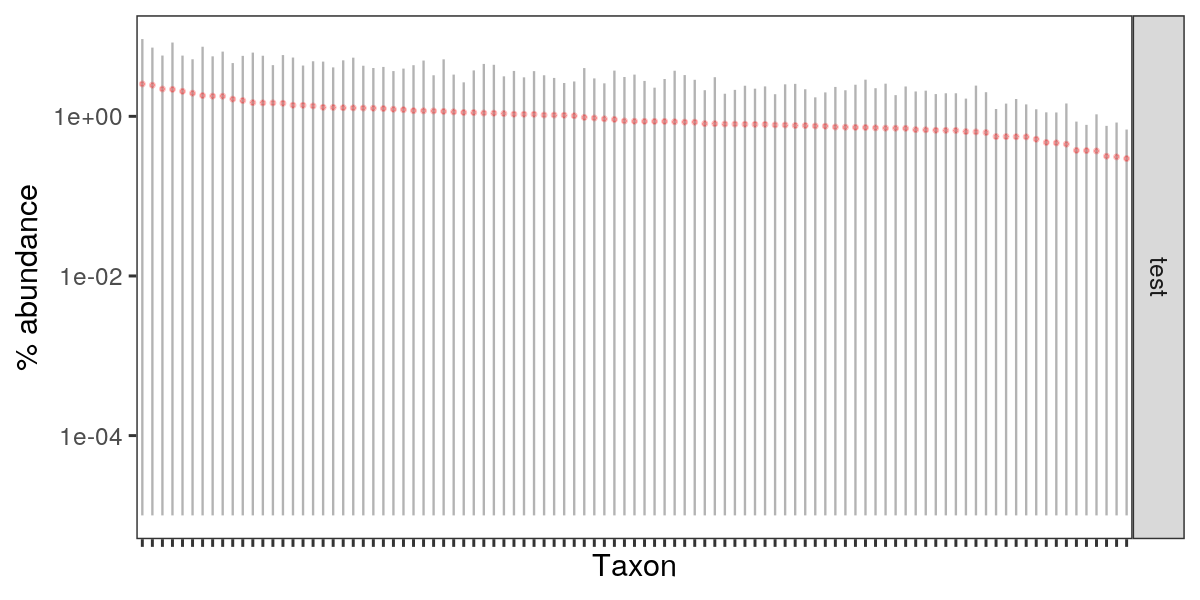

In [23]:
p.dims(6,3)
plot(p + scale_y_log10())

# Feature table summary

## Load

In [35]:
#' function to read in feature tables
read_feature_table = function(infile){
    assembler = infile %>% dirname %>% basename
    seq_depth = infile %>% dirname %>% dirname %>% basename
    sim_rep = infile %>% dirname %>% dirname %>% dirname %>% basename
    richness = infile %>% dirname %>% dirname %>% dirname %>% dirname %>% basename
    #cmd = glue::glue('gunzip -c {file} | head -n 100000', file=infile)  # <-debug
    cmd = glue::glue('gunzip -c {file}', file=infile)
    data.table::fread(cmd=cmd, sep='\t') %>%
        distinct(dataset, contig, assembler, seq_depth, sim_rep, richness, 
                 Extensive_misassembly, Extensive_misassembly_by_pos) %>%
        mutate(seq_depth = seq_depth,
               sim_rep = sim_rep,
               richness = richness) %>%
        as.data.table
}

### Test

In [36]:
F = list_files(file.path(work_dir, 'test', 'features'), 'features.tsv.gz')
F %>% length %>% print
F %>% head

[1] 60


[1] "/ebio/abt3_projects/databases_no-backup/DeepMAsED/version2/deepmased-sm/n100-r30//test/features/1/1/1000000/megahit/features.tsv.gz"    
[2] "/ebio/abt3_projects/databases_no-backup/DeepMAsED/version2/deepmased-sm/n100-r30//test/features/1/1/1000000/metaspades/features.tsv.gz" 
[3] "/ebio/abt3_projects/databases_no-backup/DeepMAsED/version2/deepmased-sm/n100-r30//test/features/1/10/1000000/megahit/features.tsv.gz"   
[4] "/ebio/abt3_projects/databases_no-backup/DeepMAsED/version2/deepmased-sm/n100-r30//test/features/1/10/1000000/metaspades/features.tsv.gz"
[5] "/ebio/abt3_projects/databases_no-backup/DeepMAsED/version2/deepmased-sm/n100-r30//test/features/1/11/1000000/megahit/features.tsv.gz"   
[6] "/ebio/abt3_projects/databases_no-backup/DeepMAsED/version2/deepmased-sm/n100-r30//test/features/1/11/1000000/metaspades/features.tsv.gz"

In [37]:
# reading in tables
doParallel::registerDoParallel(threads)
feats  = F %>%
    #head(n=3) %>%   # <-debug
    as.list %>%
    plyr::llply(read_feature_table, .parallel=TRUE) %>%
    data.table::rbindlist(use.names=TRUE) 

feats[, 'dataset' := 'test']
feats

contig,assembler,Extensive_misassembly,Extensive_misassembly_by_pos,seq_depth,sim_rep,richness,dataset
<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>
k141_22681,megahit,0,None,1000000,1,1,test
k141_29873,megahit,0,None,1000000,1,1,test
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
NODE_1882_length_3623_cov_2.922926,metaspades,0,None,1000000,9,1,test
NODE_7094_length_1471_cov_3.141243,metaspades,0,None,1000000,9,1,test


## Summarize misassemblies

### Number of misassembled contigs

In [38]:
# summarizing
feats_s = feats %>%
    distinct(dataset, contig, assembler, seq_depth, sim_rep, richness, Extensive_misassembly) %>%
    group_by(dataset, assembler, seq_depth, sim_rep, richness) %>%
    summarize(n_contigs_mis = sum(Extensive_misassembly),
              n_contigs = n()) %>%
    as_tibble 

feats_s

Warning message:
“You are using a dplyr method on a raw data.table, which will call the
* data frame implementation, and is likely to be inefficient.
* 
* To suppress this message, either generate a data.table translation with
* `lazy_dt()` or convert to a data frame or tibble with
* `as.data.frame()`/`as_tibble()`.”
Warning message:
“You are using a dplyr method on a raw data.table, which will call the
* data frame implementation, and is likely to be inefficient.
* 
* To suppress this message, either generate a data.table translation with
* `lazy_dt()` or convert to a data frame or tibble with
* `as.data.frame()`/`as_tibble()`.”


dataset,assembler,seq_depth,sim_rep,richness,n_contigs_mis,n_contigs
<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>
test,megahit,1000000,1,1,180,7999
test,megahit,1000000,10,1,215,9361
⋮,⋮,⋮,⋮,⋮,⋮,⋮
test,metaspades,1000000,8,1,253,10696
test,metaspades,1000000,9,1,137,12286


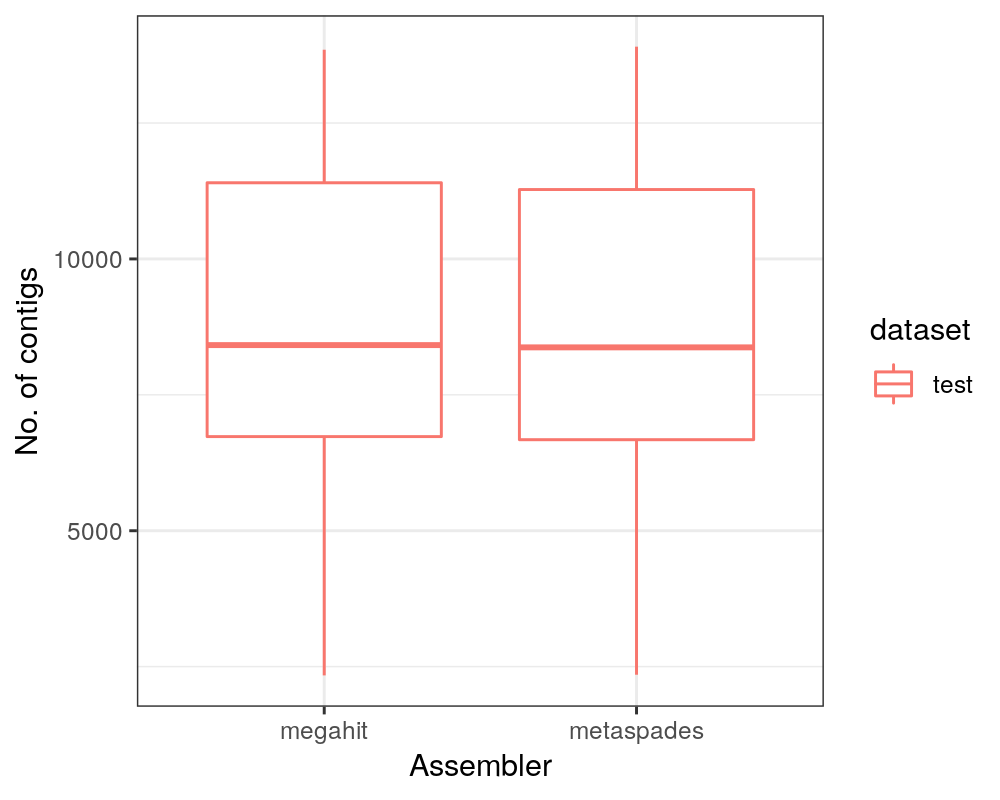

In [39]:
# number of contigs
p = feats_s %>%
    mutate(dataset = dataset %>% factor(levels=c('train', 'test'))) %>%
    ggplot(aes(assembler, n_contigs, color=dataset)) +
    geom_boxplot() +
    labs(x='Assembler', y='No. of contigs') +
    theme_bw()

p.dims(5,4)
plot(p)

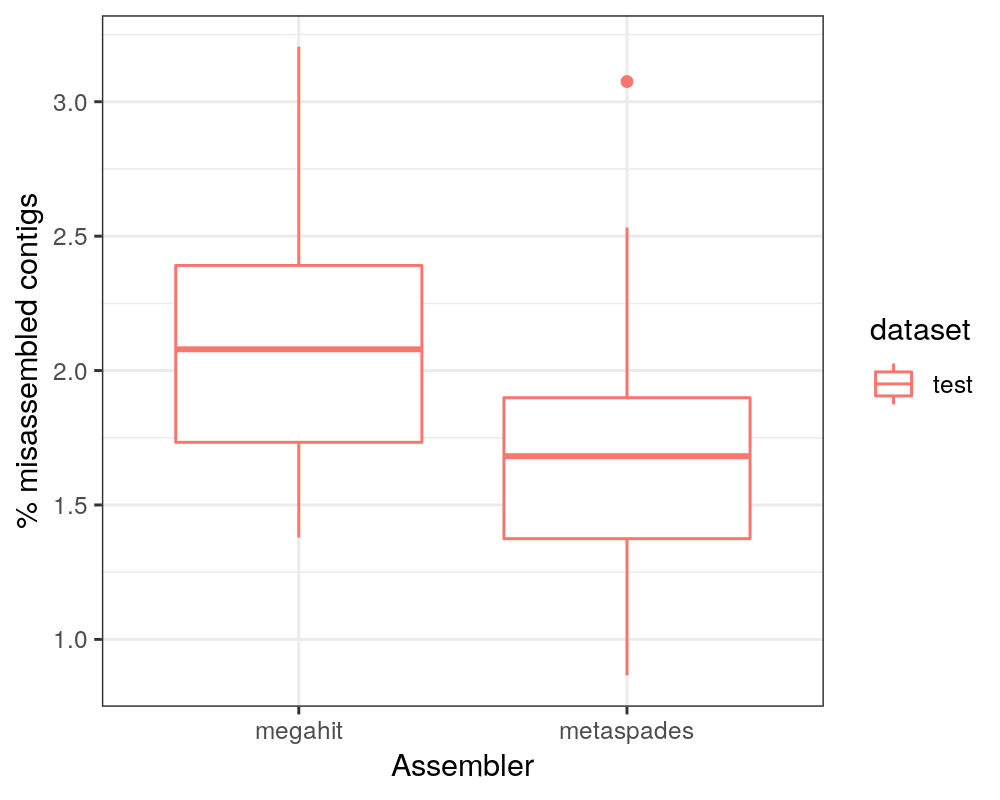

In [40]:
# number of contigs
p = feats_s %>%
    mutate(dataset = dataset %>% factor(levels=c('train', 'test'))) %>%
    mutate(perc_misasmbl = n_contigs_mis / n_contigs * 100) %>%
    ggplot(aes(assembler, perc_misasmbl, color=dataset)) +
    geom_boxplot() +
    labs(x='Assembler', y='% misassembled contigs') +
    theme_bw()

p.dims(5,4)
plot(p)

### Misassembly types

In [41]:
max_mis_per_pos = feats %>% 
    distinct(Extensive_misassembly_by_pos) %>%
    mutate(Extensive_misassembly_by_pos = gsub(' inconsistency = [0-9-]+ *', '', Extensive_misassembly_by_pos)) %>%
    as_tibble() %>%
    mutate(X = stringr::str_count(Extensive_misassembly_by_pos, ',') + 1) %>%
    .$X %>% max

cat('Max misassemblies at any position:', max_mis_per_pos, '\n')

Warning message:
“You are using a dplyr method on a raw data.table, which will call the
* data frame implementation, and is likely to be inefficient.
* 
* To suppress this message, either generate a data.table translation with
* `lazy_dt()` or convert to a data frame or tibble with
* `as.data.frame()`/`as_tibble()`.”
Warning message:
“You are using a dplyr method on a raw data.table, which will call the
* data frame implementation, and is likely to be inefficient.
* 
* To suppress this message, either generate a data.table translation with
* `lazy_dt()` or convert to a data frame or tibble with
* `as.data.frame()`/`as_tibble()`.”


Max misassemblies at any position: 6 


In [42]:
# summarizing
tmp_cols = sapply(LETTERS[1:max_mis_per_pos], function(x) glue::glue('TMP_{x}', x=x))

feats_s = feats %>%
    distinct(dataset, contig, assembler, seq_depth, sim_rep, richness, 
             Extensive_misassembly, Extensive_misassembly_by_pos) %>%
    mutate(Extensive_misassembly_by_pos = gsub(' inconsistency = [0-9-]+ *', '', 
                                               Extensive_misassembly_by_pos)) %>%
    as_tibble() %>%
    separate(Extensive_misassembly_by_pos, tmp_cols, sep=',') %>%
    gather(Extensive_misassembly_type, Extensive_misassembly_value, starts_with('TMP_')) %>%
    filter(!is.na(Extensive_misassembly_value),
           Extensive_misassembly_value != 'None',
           Extensive_misassembly_value != '')

feats_s

Warning message:
“You are using a dplyr method on a raw data.table, which will call the
* data frame implementation, and is likely to be inefficient.
* 
* To suppress this message, either generate a data.table translation with
* `lazy_dt()` or convert to a data frame or tibble with
* `as.data.frame()`/`as_tibble()`.”
Warning message:
“You are using a dplyr method on a raw data.table, which will call the
* data frame implementation, and is likely to be inefficient.
* 
* To suppress this message, either generate a data.table translation with
* `lazy_dt()` or convert to a data frame or tibble with
* `as.data.frame()`/`as_tibble()`.”
Warning message:
“Expected 6 pieces. Missing pieces filled with `NA` in 521181 rows [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, ...].”


dataset,contig,assembler,seq_depth,sim_rep,richness,Extensive_misassembly,Extensive_misassembly_type,Extensive_misassembly_value
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>
test,k141_30537,megahit,1000000,1,1,1,TMP_A,translocation
test,k141_30537,megahit,1000000,1,1,1,TMP_A,translocation
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
test,k141_25539,megahit,1000000,9,1,1,TMP_E,relocation
test,NODE_1065_length_5270_cov_3.707958,metaspades,1000000,9,1,1,TMP_E,relocation


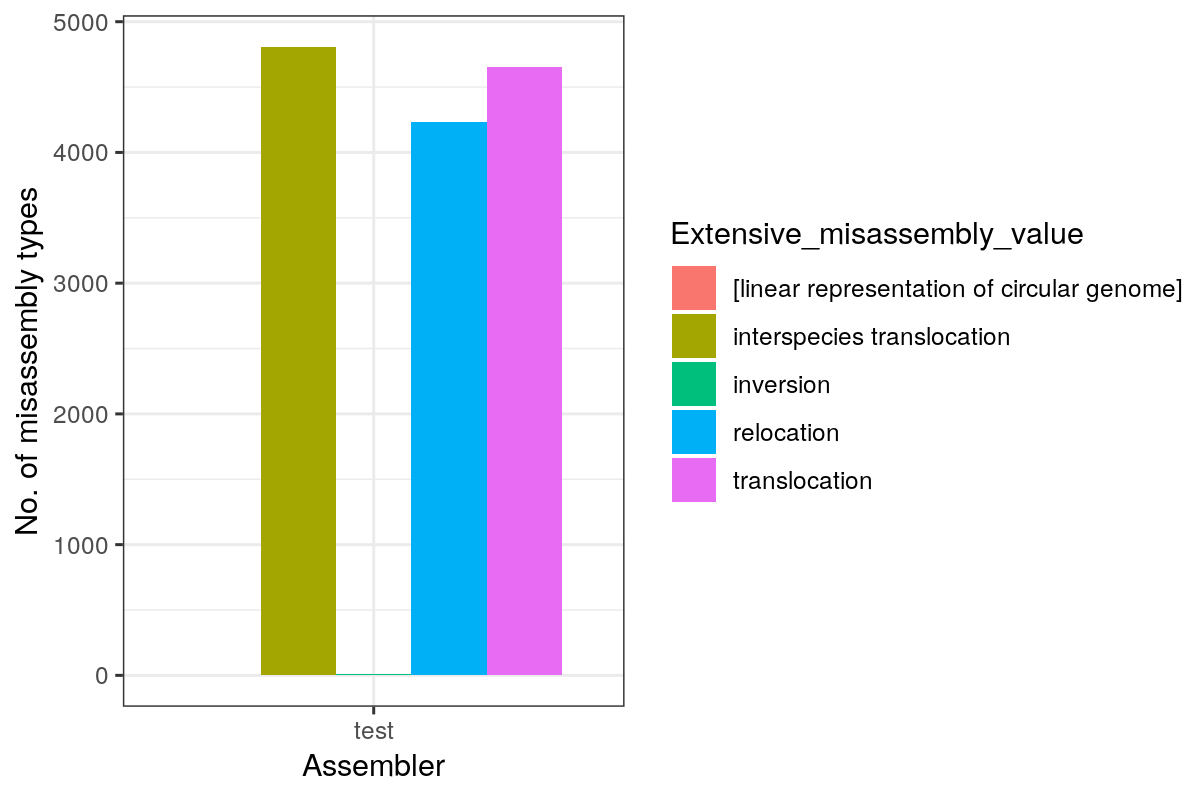

In [43]:
# number of contigs
p = feats_s %>%
    group_by(dataset, Extensive_misassembly_value) %>%
    summarize(n = n()) %>%
    ungroup() %>%
    mutate(dataset = dataset %>% factor(levels=c('train', 'test'))) %>%
    ggplot(aes(dataset, n, fill=Extensive_misassembly_value)) +
    geom_bar(stat='identity', position='dodge') +
    labs(x='Assembler', y='No. of misassembly types') +
    theme_bw()

p.dims(6,4)
plot(p)

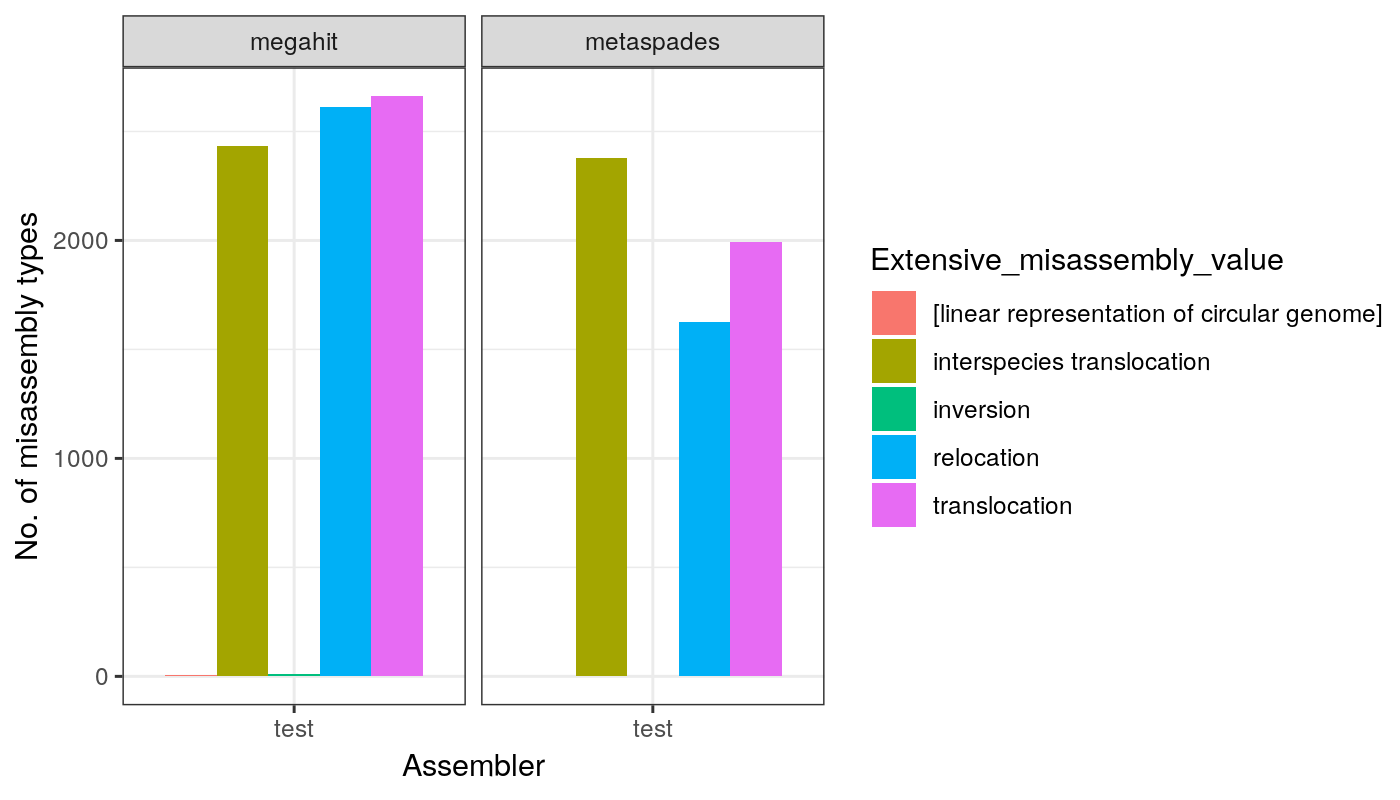

In [44]:
# number of contigs
p = feats_s %>%
    group_by(dataset, assembler, Extensive_misassembly_value) %>%
    summarize(n = n()) %>%
    ungroup() %>%
    mutate(dataset = dataset %>% factor(levels=c('train', 'test'))) %>%
    ggplot(aes(dataset, n, fill=Extensive_misassembly_value)) +
    geom_bar(stat='identity', position='dodge') +
    facet_wrap(~ assembler) +
    labs(x='Assembler', y='No. of misassembly types') +
    theme_bw()

p.dims(7,4)
plot(p)

#### Notes/WARNINGs

1. Due to the per-position extensive misassembly coding, the counts above are not accurate. This is a result of overlapping misassemblies. 
  1. That data can be directly obtained from the `contigs_report_contigs_filtered.mis_contigs.info` files created by metaQUAST for each simulation
1. need to change parsing code to filter out `[linear representation of circular genome]` 

In [46]:
# clearing memory
feats = NULL
feats_s = NULL

# sessionInfo

In [47]:
sessionInfo()

R version 3.6.2 (2019-12-12)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.3 LTS

Matrix products: default
BLAS/LAPACK: /ebio/abt3_projects/Georg_animal_feces/envs/tidyverse/lib/libopenblasp-r0.3.7.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] LeyLabRMisc_0.1.1 dtplyr_1.0.0      data.table_1.12.8 ggplot2_3.2.1    
[5] tidyr_1.0.0       dplyr_0.8.3      

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.3        plyr_1.8.5        pillar_1.4.3      compiler_3.6.2   
 [5] iterators_1.0.12  base64enc_0.1-3   tool